Your goal is to generate output like the image shown above. To do that, you need to write a function that takes your distorted image as input and completes the following steps:

1. Undistort the image using cv2.undistort() with mtx and dist
2. Convert to grayscale
3. Find the chessboard corners
4. Draw corners
5. Define 4 source points (the outer 4 corners detected in the chessboard pattern)
6. Define 4 destination points (must be listed in the same order as src points!)
7. Use cv2.getPerspectiveTransform() to get M, the transform matrix
8. Use cv2.warpPerspective() to apply M and warp your image to a top-down view


# 0. Step

Step1: Camera Calibration
Purpose: To compute the transformation between 3D object points in the world and 2D image points

Step2: Distortion Correction
Purpose: To ensure that the geometrical shape of objects is represented consistently, no matter where they appear in an image

Step3: Color/gradient threshold

Step4: Perspective Transform
Purpose: To transform an image such that we are effectively viewing objects from a different angle or direction. 

# 1. An example of a distortion-corrected image.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import matplotlib
matplotlib.use('TkAgg')

%matplotlib inline
#%matplotlib qt

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()


In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/GOPR0032.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "test_images/wide_dist_pickle.p", "wb" ) )

In [4]:
dist_pickle = pickle.load( open( "test_images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

In [5]:
def corners_unwarp_2(img, nx, ny):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    img_size= (img.shape[1], img.shape[0])
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners= cv2.findChessboardCorners(gray,(nx,ny),None)
    offset=100
    
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M


In [6]:
#top_down, perspective_M = corners_unwarp(img, nx, ny,mtx, dist)
top_down, perspective_M = corners_unwarp_2(dst, nx, ny)

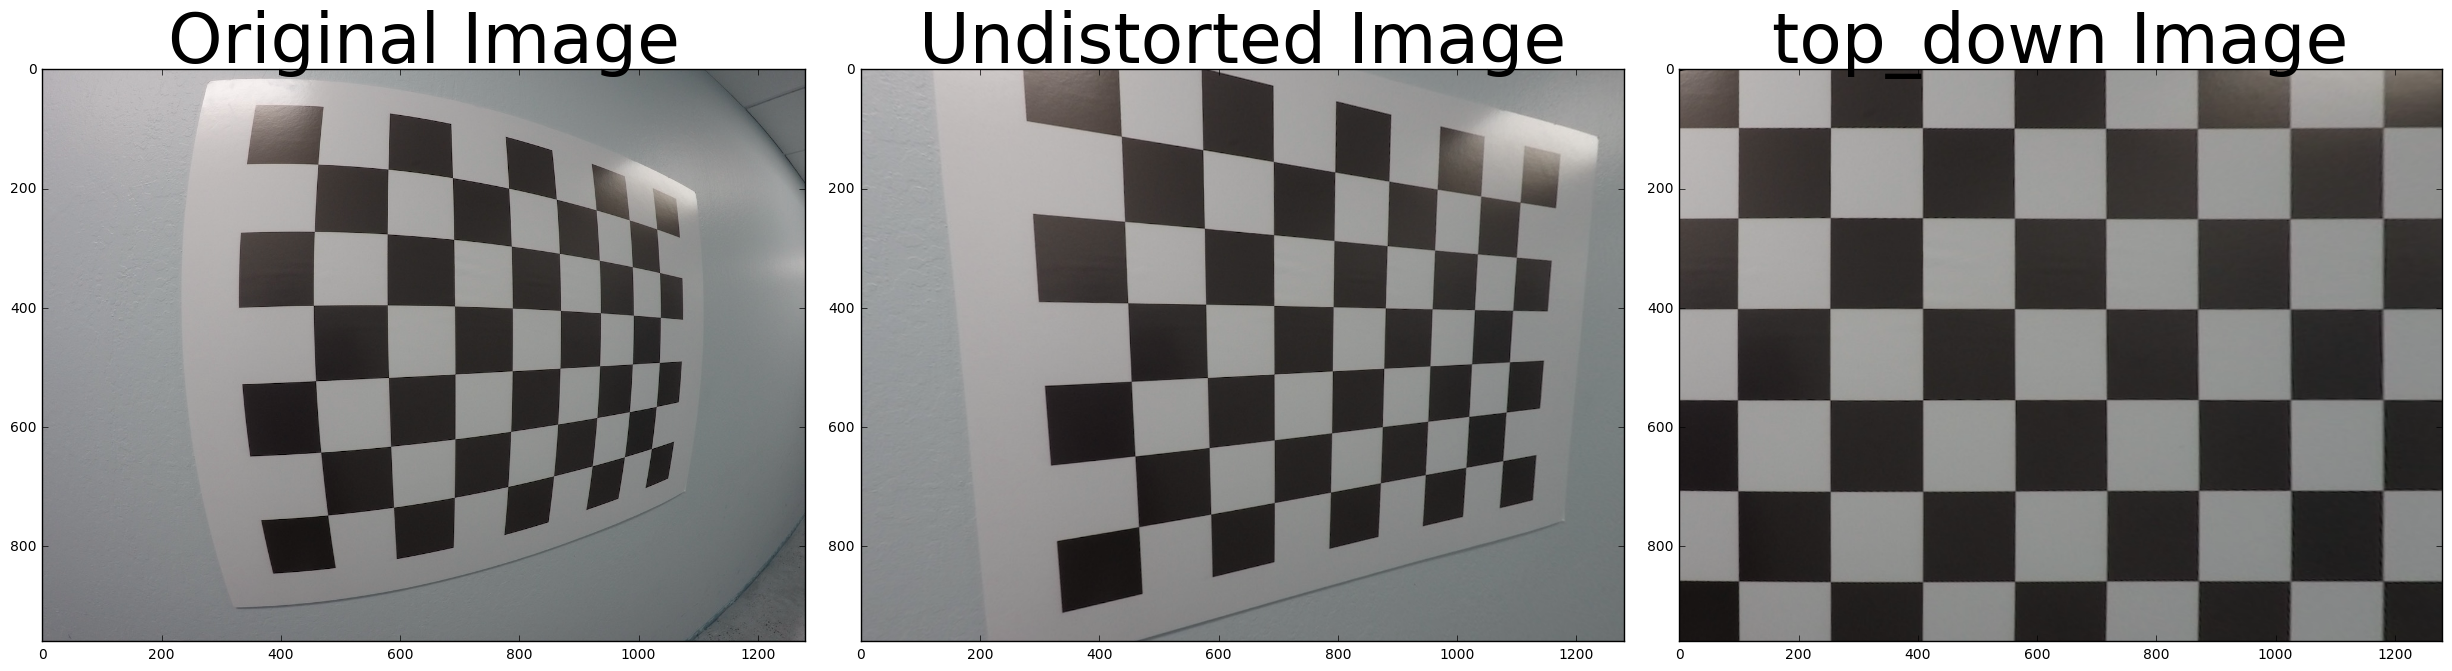

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax3.imshow(top_down)
ax3.set_title('top_down Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# 2. A thresholded binary image

Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [8]:
# Remove distortion from images
def undistort(img, show=True, read = True):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [9]:
img = mpimg.imread('test_cars/test1.jpg',0)
undistorted_img=undistort(img)

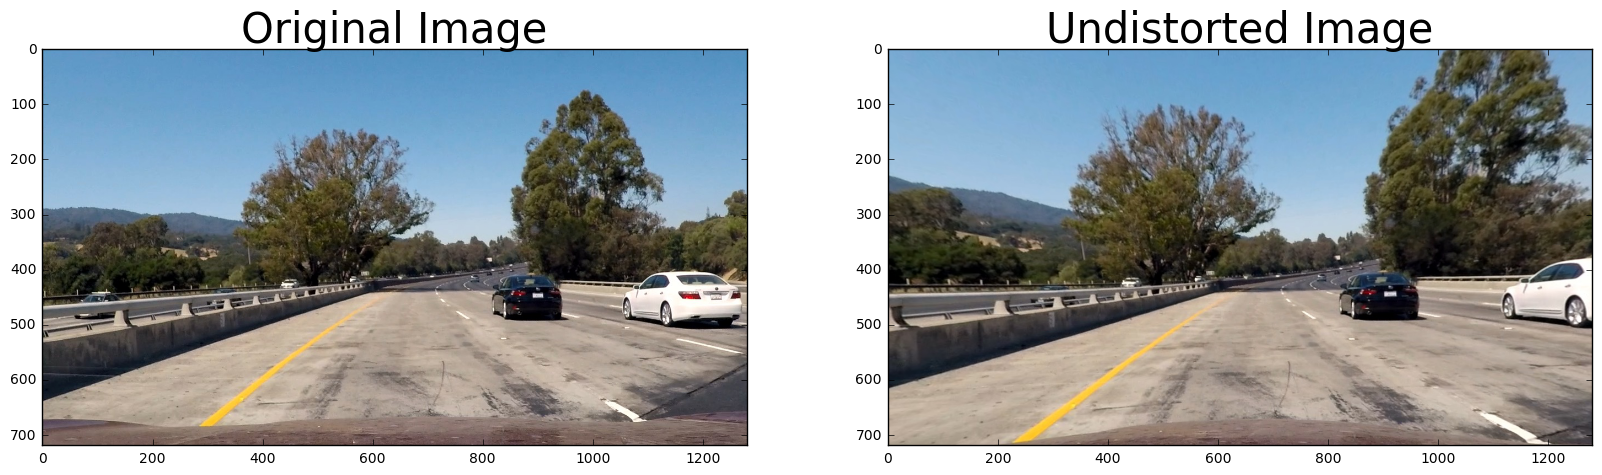

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(undistorted_img,cmap = plt.get_cmap('gray'))
import pylab
ax2.imshow(undistorted_img,cmap ='gray')
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

In [11]:
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
thresh_s = (90, 255)
binary_s = np.zeros_like(S)
binary_s[(S > thresh_s[0]) & (S <= thresh_s[1])] = 1

thresh_h = (50, 200)
binary_h = np.zeros_like(H)
binary_h[(H > thresh_h[0]) & (H <= thresh_h[1])] = 1

thresh_l = (80,200)
binary_l = np.zeros_like(L)
binary_l[(L > thresh_l[0]) & (L <= thresh_l[1])] = 1

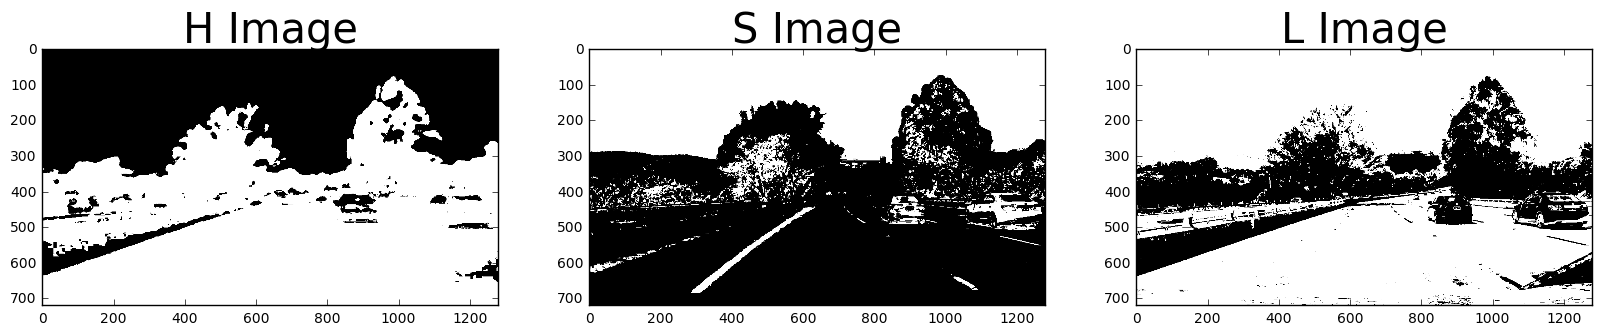

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(binary_h,cmap = plt.get_cmap('gray'))
ax1.set_title('H Image', fontsize=30)
ax2.imshow(binary_s,cmap = plt.get_cmap('gray'))
ax2.set_title('S Image', fontsize=30)
ax3.imshow(binary_l,cmap = plt.get_cmap('gray'))
ax3.set_title('L Image', fontsize=30)

In [13]:


def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    # Apply threshold
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        # Apply threshold
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(image, sthresh=(90,255), vthresh=(200,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])  ] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])  ] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

# Retuns binary image based on thresholding functions
def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    #light_mask[(S >= 5) & (L >= 130)] = 1
    light_mask[((S >= 20) & (S<= 255)) & ((L >= 25) & (L<= 255))] = 1
    
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresh(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
    gradx_s = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    combined = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # Mix results from either channels
    combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    
    return combined

'''
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output



def final_threshold(img):

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 90
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (b_binary == 1)] = 1
    return combined_binary

def pipeline1(img):
    # undistort the image 
    img = cv2.undistort(img,mtx,dist,None,mtx)
    gradx = abs_sobel_thresh(img, orient='x', thresh=(20,255)) 
    grady = abs_sobel_thresh(img, orient='y', thresh=(20,255)) 
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 150))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(20, 255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_final= np.zeros_like(combined)
    #combined_final[((combined == 1)|(hls_binary ==1))] =1
    combined_final[((combined == 1) & (hls_binary ==1))|((hls_binary ==1) & (mag_binary == 1))] =1
    return combined_final

'''

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids



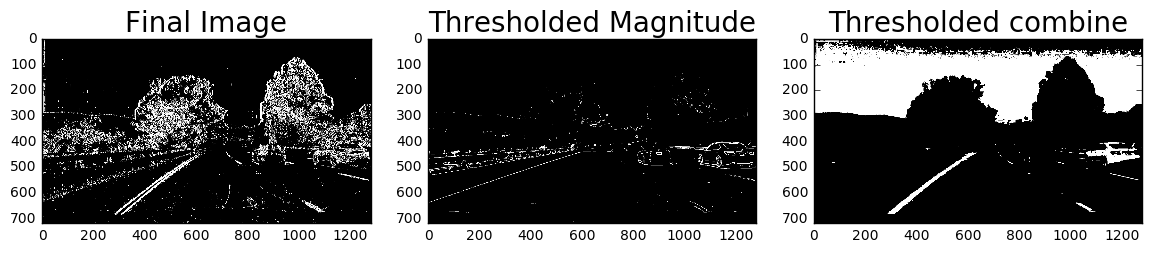

In [14]:

grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 130))
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(80, 255))
pip_binary= get_binary_image(img)
color_binary= color_threshold(img)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))
f.tight_layout()
ax1.imshow(pip_binary, cmap='gray')
ax1.set_title('Final Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=20)
ax3.imshow(color_binary, cmap='gray')
ax3.set_title('Thresholded combine', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

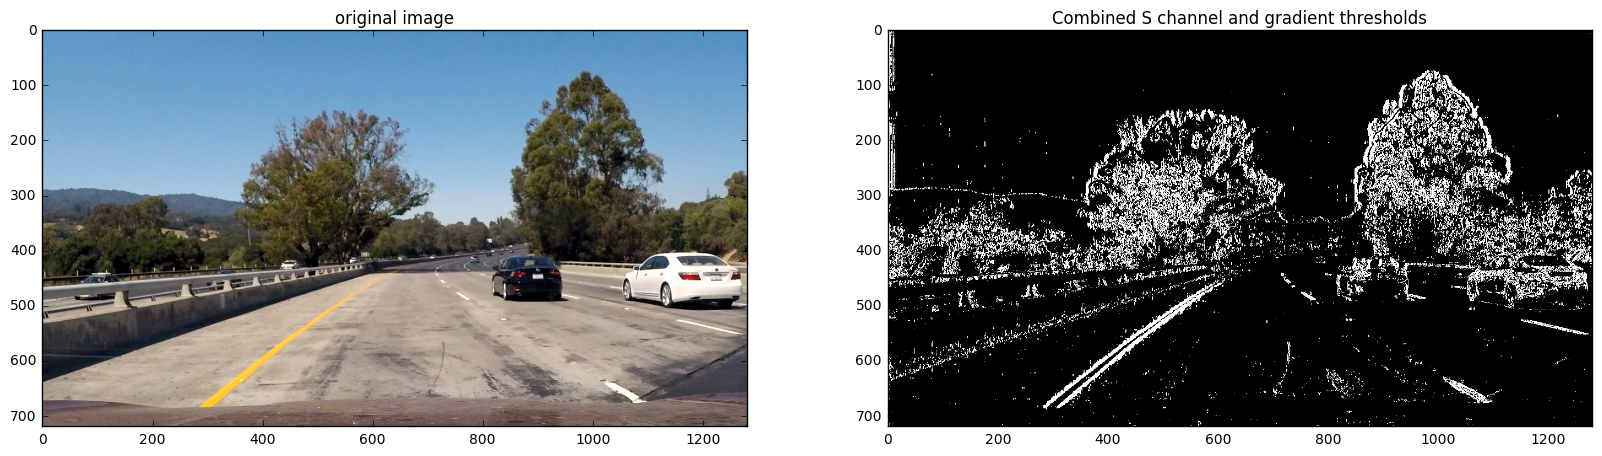

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image')
ax1.imshow(img,cmap = plt.get_cmap('gray'))

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(pip_binary, cmap='gray')

# 3. Perspective transform

Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

Purpose: To transform an image such that we are effectively viewing objects from a different angle or direction. 

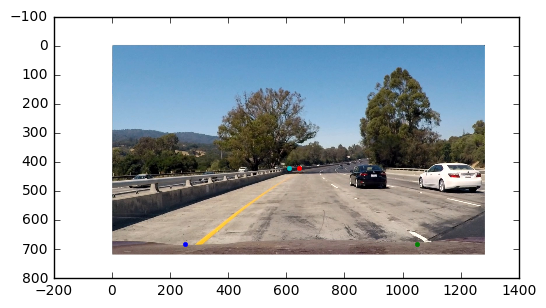

In [16]:


#plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.imshow(img)

plt.plot(250,680,'.') # bottom left
plt.plot(1050,680,'.') # bottom right
plt.plot(645,420,'.') # top right
plt.plot(610,420,'.') # top left

 



In [17]:

def warp(image):
    
    img_size= (image.shape[1], image.shape[0])
    
    '''
    area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    #four source coordinates
    src=np.float32(
        [[300,680],
         [1100,680],
         [820,520],
         [530,520]])
    dst=np.float32(
        [[300, 680],
        [1000,680],
        [1000, 50],
        [340,0]
        ])
    
    src=np.float32(
        [[250,680],
         [1050,680],
         [700,440],
         [600,440]])
    dst=np.float32(
        [[250, 680],
        [1000,680],
        [1400, 0],
        [150,0]
        ])
    

    #four desired coordinates
    
    '''
    src=np.float32(
        [[250,680],
         [1050,680],
         [700,450],
         [600,450]])

    dst=np.float32(
        [[250, 680],
        [970,680],
        [1070, 0],
        [300,0]
        ])


    M= cv2.getPerspectiveTransform(src, dst)
    Minv= cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [18]:
#warped_im= warp(result_pip)
#warped_im= warp(result_pip)
warped_im=warp(pip_binary)
#warped_pro=warp(pro_binary)

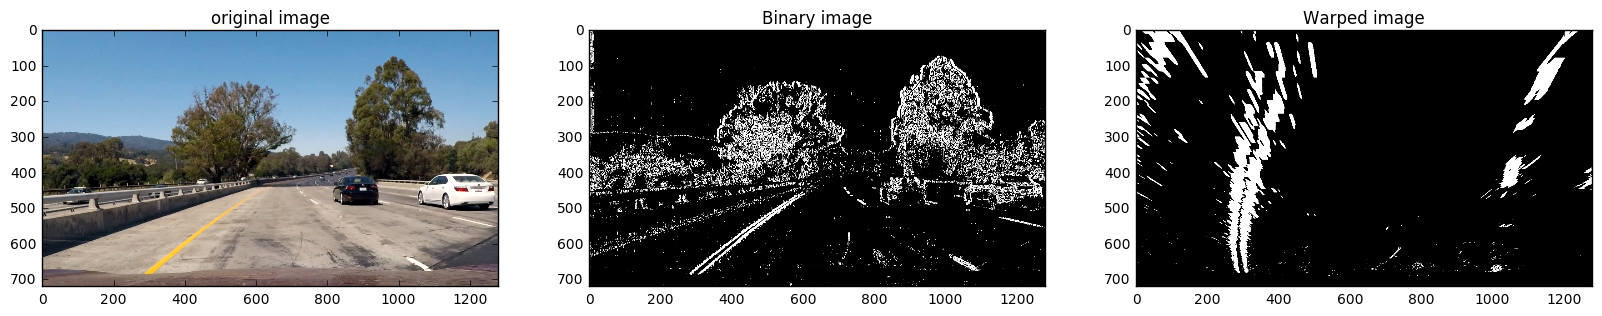

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('original image')
ax1.imshow(img,cmap = plt.get_cmap('gray'))
ax2.set_title('Binary image')
ax2.imshow(pip_binary, cmap='gray')
ax3.set_title('Warped image')
ax3.imshow(warped_im, cmap='gray')

# 4. Picture positions with a polynomial

Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


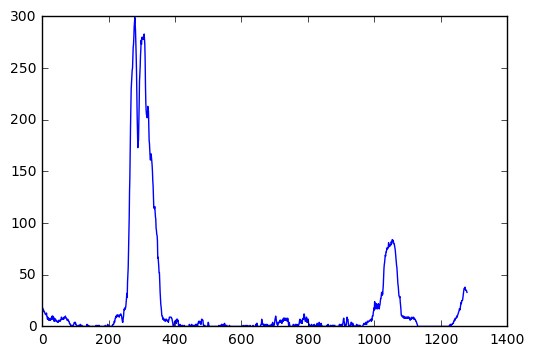

In [20]:
histogram= np.sum(warped_im[warped_im.shape[0]/2:,:],axis=0)
out_img=np.dstack((warped_im, warped_im, warped_im))*255
midpoint=np.int(histogram.shape[0]/2)
leftx_base=np.argmax(histogram[:midpoint])
rightx_base=np.argmax(histogram[midpoint:])+midpoint
plt.plot(histogram)

In [21]:
window_centroids = find_window_centroids(warped_im, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped_im)
    r_points = np.zeros_like(warped_im)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped_im,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped_im,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped_im,warped_im,warped_im)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped_im,warped_im,warped_im)),np.uint8)

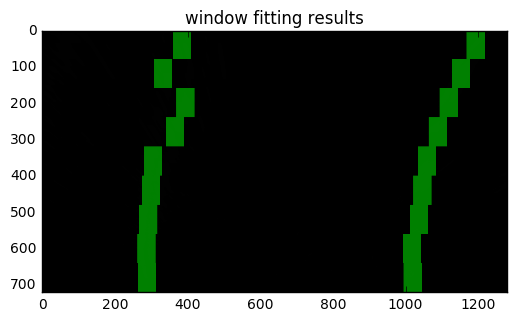

In [22]:
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [23]:
nwindows=9
window_height=np.int(output.shape[0]/nwindows)

nonzero=output.nonzero()
nonzeroy=np.array(nonzero[0])
nonzerox=np.array(nonzero[1])

leftx_current=leftx_base
rightx_current=rightx_base

margin=100
minpix=50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [24]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = output.shape[0] - (window+1)*window_height
    win_y_high = output.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

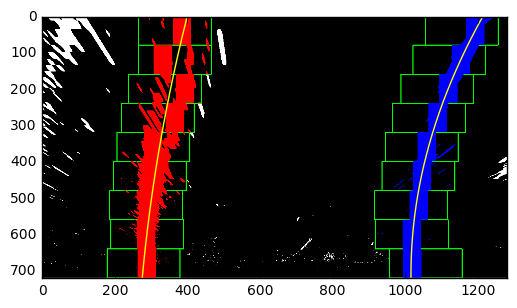

In [25]:
# Generate x and y values for plotting
ploty = np.linspace(0, output.shape[0]-1, output.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# 5. Calculate the radius of curvature of the lane and the position of the vehicle

Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [26]:
y_eval = np.max(ploty)
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1477.01562095 m 419.27515753 m


# 6. Warp lanes 

Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly

In [27]:
# Create an image to draw the lines on
rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
# Calculate the position of the vehicle
warp_zero = np.zeros_like(warped_im).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

'''

    src=np.float32(
        [[250,680],
         [1050,680],
         [700,450],
         [600,450]])

    dst=np.float32(
        [[250, 680],
        [970,680],
        [1070, 0],
        [300,0]
        ])

src=np.float32([[300,680],[1100,680],[820,520],[530,520]])
dst=np.float32([[300, 680],[1000,680],[1000, 50],[340,0]])

'''
src=np.float32([[250,680],[1050,680],[700,450],[600,450]])
dst=np.float32([[250, 680],[970,680],[1070, 0],[300,0]])



Minv= cv2.getPerspectiveTransform(dst, src)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
font = cv2.FONT_HERSHEY_SIMPLEX
center = abs(640 - ((rightx_int+leftx_int)/2))

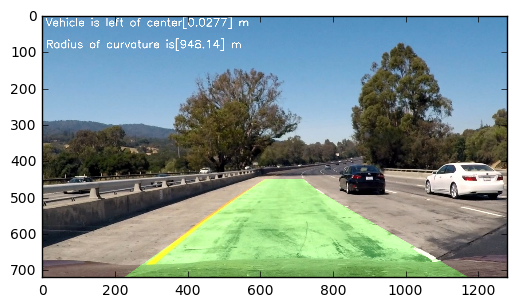

In [28]:
if center < 640:
    cv2.putText(img,'Vehicle is left of center' +'['+str(center*3.7/700)[:6] + '] m',
                   (10,30),font,1,(255,255,255),2)
else:
    cv2.putText(img,'Vehicle is right of center' +'['+str(center*3.7/700)[:6] + '] m',
                   (10,30),font,1,(255,255,255),2)
    
cv2.putText(img,'Radius of curvature is' +'['+str((left_curverad + right_curverad)/2)[:6] + '] m',
                   (10,90),font,1,(255,255,255),2)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)


plt.imshow(result)